In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
#warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

2024-07-16 07:58:41.282357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 07:58:41.282500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 07:58:41.479733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
diamonds = pd.read_csv("/kaggle/input/diamonds/diamonds.csv")
diamonds.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


We can drop the unnamed:0 column

In [4]:
diamonds.drop(diamonds.columns[0],axis=1,inplace=True)
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


We got 3 object dtype columns that we will need to deal with later before the modeling phase

In [5]:
diamonds.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [6]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


We can notice that on the variables x,y,z we got 0 as a minimum entry. This is probably due to wrong input and we can safely remove those. Lets also check with .shape how many entries we got before and how many will be removed

In [7]:
diamonds.shape

(53940, 10)

In [8]:
diamonds = diamonds[(diamonds["x"] != 0) & (diamonds["y"] != 0) & (diamonds["z"] != 0)]
diamonds.shape

(53920, 10)

Just 20 entries were removed

In [9]:
#sns.pairplot(diamonds,hue="cut")
#plt.show()

<a href="https://ibb.co/0cxXMCK"><img src="https://i.ibb.co/zrz5RXF/1.png" alt="1" border="0"></a>

Looks like we have outliers for the columns depth, table, x, y, and z. Lets do some boxplots to see this more clearly

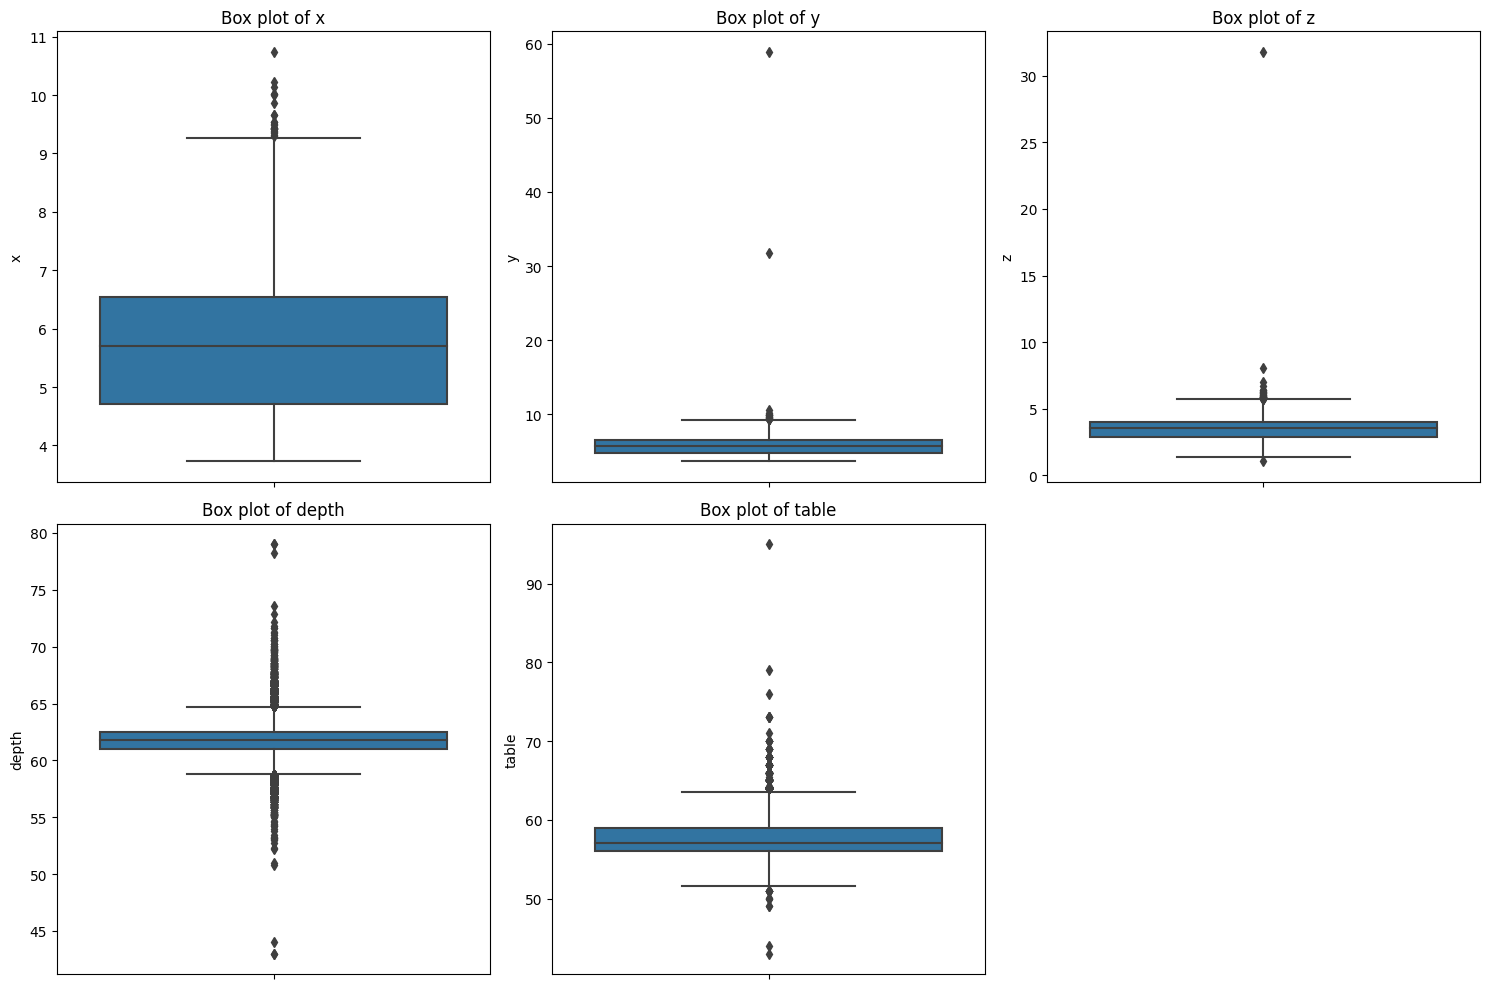

In [10]:
columns_to_check = ['x', 'y', 'z', 'depth', 'table']
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=diamonds[column])
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()

In [11]:
df = diamonds.copy()
def detect_outliers(df, columns):
    outliers = {}
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

outliers = detect_outliers(df, columns_to_check)
outliers_count = sum(len(outlier_values) for outlier_values in outliers.values())
outliers_count

3222

From the above we can clearly see that we have quite a few outliers. Using the IQR method we got 3222 outliers which we can drop

In [12]:
outlier_indices = set()
for outlier_values in outliers.values():
    outlier_indices.update(outlier_values.index)
df = df.drop(index=outlier_indices)

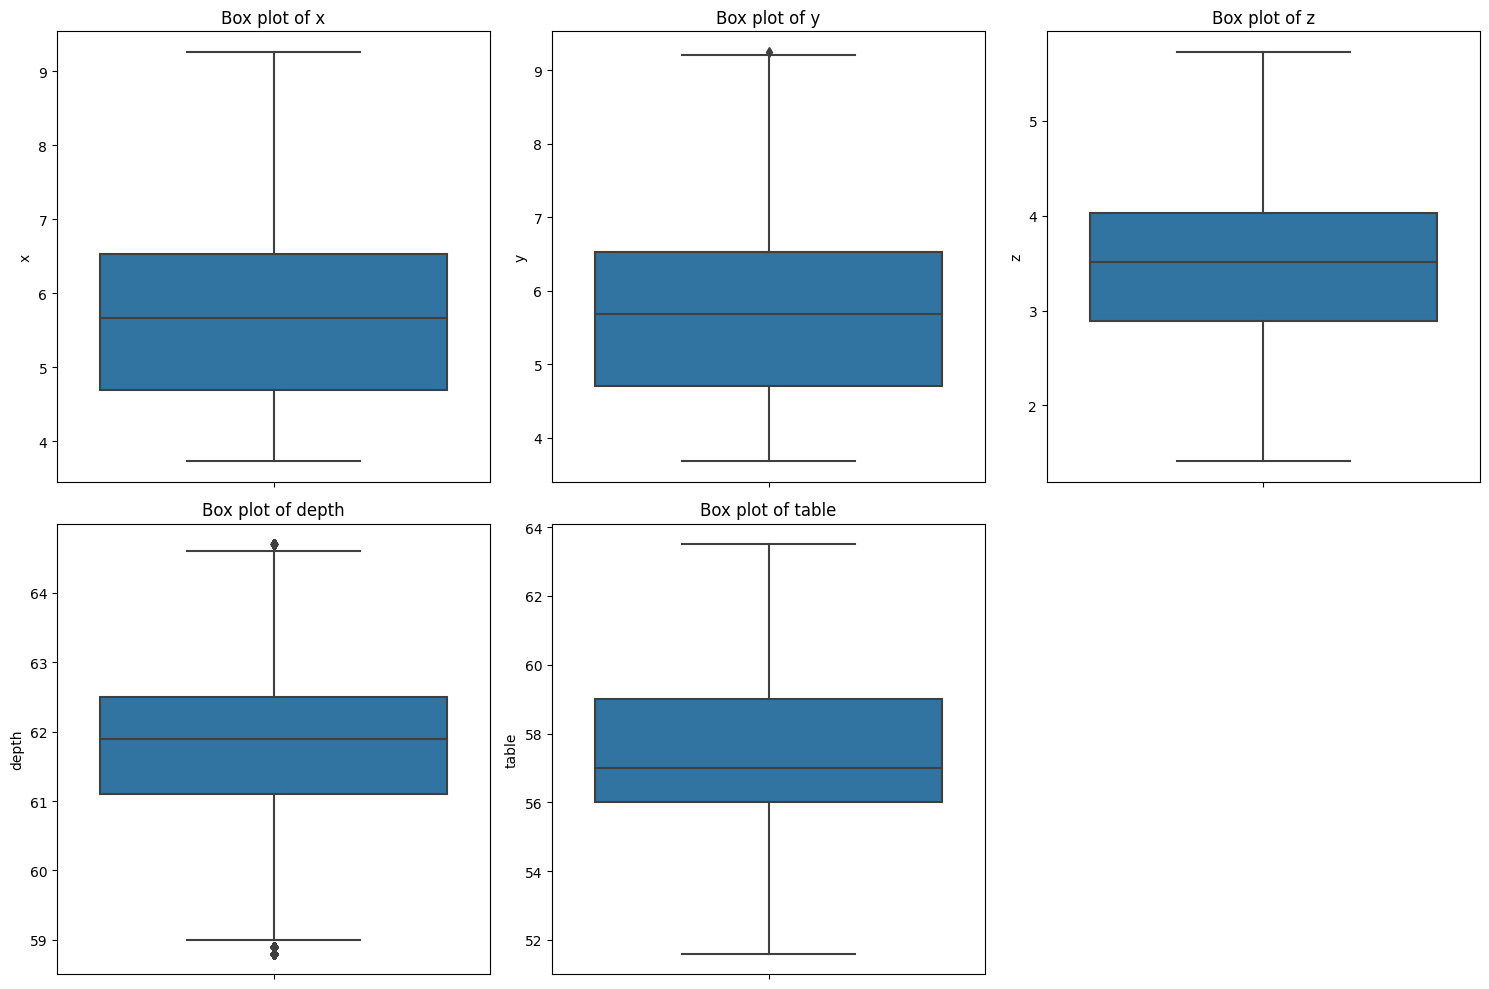

In [13]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()

This is much cleaner now. So lets also do the pairplot again to see the difference.

In [14]:
#sns.pairplot(df,hue="cut")
#plt.show()

<a href="https://ibb.co/L5TBSRV"><img src="https://i.ibb.co/xHnwhLx/2.png" alt="2" border="0"></a>

Before we consider going into modeling phase we need to deal with those object dtype columns we saw at the start. 

In [15]:
categorical_cols = ["cut","color","clarity"]
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])
df.head(10)    

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75
5,0.24,4,6,7,62.8,57.0,336,3.94,3.96,2.48
6,0.24,4,5,6,62.3,57.0,336,3.95,3.98,2.47
7,0.26,4,4,2,61.9,55.0,337,4.07,4.11,2.53
9,0.23,4,4,4,59.4,61.0,338,4.00,4.05,2.39
10,0.30,1,6,2,64.0,55.0,339,4.25,4.28,2.73
11,0.23,2,6,4,62.8,56.0,340,3.93,3.90,2.46


Now that this is dealt with we can proceed to make a model that will predict the price of a diamond based on the other variables

<Axes: >

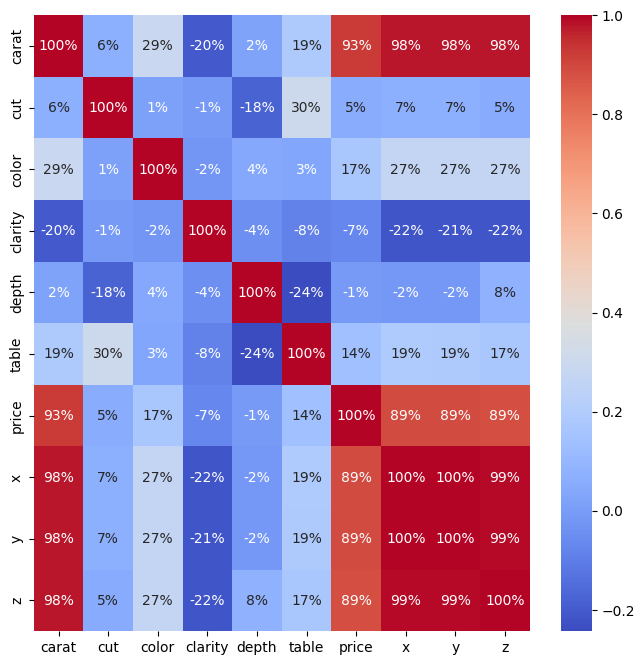

In [16]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),annot=True,fmt='.0%',cmap='coolwarm')

Lets split the data and scale our variables first

In [17]:
X = df.drop('price',axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [18]:
X_train.head(10)

,carat,cut,color,clarity,depth,table,x,y,z
24233,1.672367,-0.669897,-0.348504,-1.084927,-0.614069,-1.135862,1.652005,1.641141,1.573166
2405,-0.101757,-0.669897,0.826304,0.658487,0.373838,-1.135862,0.111347,0.090628,0.136307
35602,-1.020882,0.388923,0.826304,1.239625,0.104409,0.343243,-1.223294,-1.252549,-1.227984
15942,0.453993,-0.669897,0.238900,0.658487,0.553457,0.836278,0.586085,0.622490,0.658801
45305,-1.042257,-0.669897,-1.523312,-1.084927,0.104409,-1.135862,-1.250166,-1.225505,-1.227984
18327,1.544117,0.388923,2.001112,0.658487,1.092315,-0.149792,1.499731,1.424790,1.587680
22760,1.971617,-0.669897,2.001112,0.077349,0.553457,-0.642827,1.723664,1.695229,1.776358
30903,-0.849882,-0.669897,0.238900,0.658487,-0.254830,-0.149792,-0.909787,-0.873936,-0.908682
18873,0.689117,-0.669897,-0.348504,0.658487,-0.165020,-0.149792,0.845847,0.865884,0.832966
11847,0.518118,0.388923,-0.935908,-1.084927,-0.434449,1.329313,0.738359,0.721651,0.687829


For starters lets use a linear regression model

In [19]:
skmodel = LinearRegression()
skmodel.fit(X_train, y_train)

y_skpred = skmodel.predict(X_test)
mae = mean_absolute_error(y_test, y_skpred)
r2sk = r2_score(y_test, y_skpred)
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R-squared: {r2sk:.3f}")

Mean Absolute Error: 807.045
R-squared: 0.901


The model explains 90.1% of the variance of our data and MAE is ok. Surely there is rool for improvement. We can try an XGB model next

In [20]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.4f}")
print(f"R-squared: {r2:.3f}")

Test MAE: 263.6569
R-squared: 0.982


This is much better. XGB model explains 98.2% of the variance of our data and has a much smaller MAE than that of our linear model. We can perhaps finetune it with a grid search for better results

In [21]:
# param_grid = {
#     'learning_rate': [0.1, 0.05, 0.01],
#     'max_depth': [5, 7, 9],
#     'n_estimators': [200, 300, 500],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'gamma': [0, 0.1, 0.2]
# }

# xgb = XGBRegressor()
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
#                            cv=3, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

# grid_search.fit(X_train, y_train)

{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 9,
 'n_estimators': 500,
 'subsample': 1.0}

In [22]:
best_xgb = xgb.XGBRegressor(
    colsample_bytree=0.9,
    gamma=0,
    learning_rate=0.05,
    max_depth=9,
    n_estimators=500,
    subsample=1.0,
    objective='reg:squarederror',
    random_state=42
)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {test_mae:.4f}")
print(f"R-squared: {test_r2:.3f}")

Test MAE: 246.5606
R-squared: 0.983


Seems like we got a marginal performance increase

How would a neural network fare though?

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 30833922.0000 - mae: 3889.7275 - val_loss: 31193724.0000 - val_mae: 3914.1272
Epoch 2/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 30419392.0000 - mae: 3875.1704 - val_loss: 30116410.0000 - val_mae: 3846.3604
Epoch 3/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 30017398.0000 - mae: 3875.5024 - val_loss: 28612478.0000 - val_mae: 3739.8342
Epoch 4/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 28457784.0000 - mae: 3763.1396 - val_loss: 26856482.0000 - val_mae: 3629.5759
Epoch 5/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 26445944.0000 - mae: 3638.3066 - val_loss: 24867108.0000 - val_mae: 3511.4658
Epoch 6/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 24926744.0000 - mae: 3528.7153 - val_loss: 22820804.0000 - val_mae: 3374.6582
Epoch 7/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 22245448.0000 - mae: 3330.3870 - val_loss: 20704448.0000 - val_mae: 3212.2341
Epoch 8/30
510/510 ━━━━━━━━━━━━━━━

In [24]:
test_loss, test_mae = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'Test MAE: {test_mae}')
print(f"R-squared: {r2:.3f}")

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 579298.3125 - mae: 444.0565
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test MAE: 448.1356201171875
R-squared: 0.961


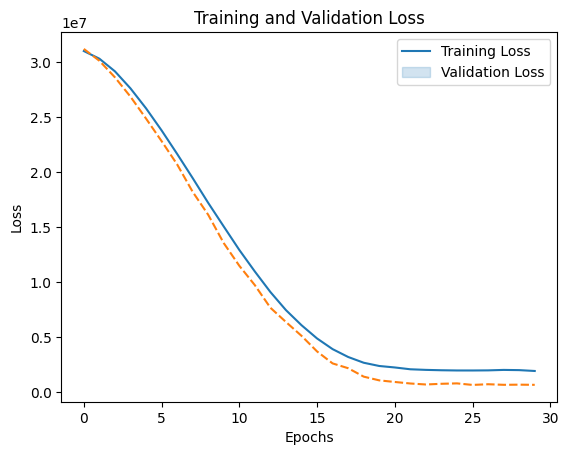

In [25]:
history_df = pd.DataFrame(history.history)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

This is not certainly as good as the XGB model but still better than the linear regression one